# Libraries

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import datetime
from skorch import NeuralNetRegressor

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1492 entries, 1 to 1492
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   INPUT0    1492 non-null   float64
 1   INPUT1    1492 non-null   float64
 2   INPUT2    1492 non-null   float64
 3   INPUT3    1492 non-null   float64
 4   INPUT4    1492 non-null   float64
 5   INPUT5    1492 non-null   float64
 6   INPUT6    1492 non-null   float64
 7   INPUT7    1492 non-null   float64
 8   INPUT8    1492 non-null   float64
 9   TARGET_X  1492 non-null   float64
 10  TARGET_Y  1492 non-null   float64
dtypes: float64(11)
memory usage: 139.9 KB


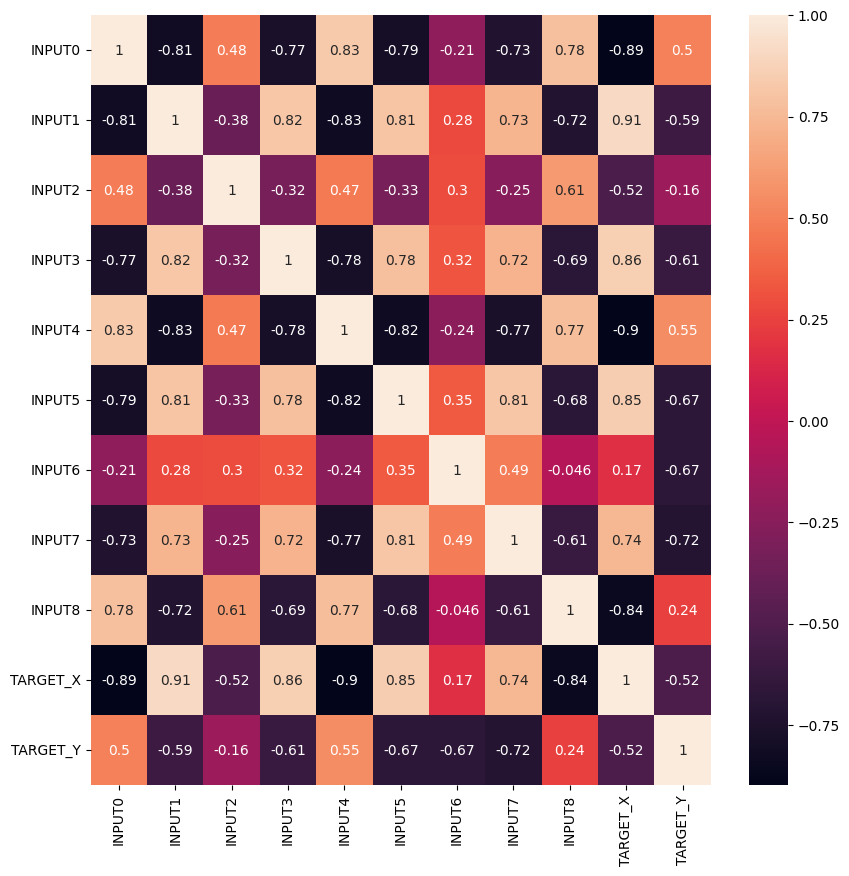

x_train  (1044, 9)
y_train  (1044, 2)
x_test  (448, 9)
y_test  (448, 2)


In [2]:
from set_extraction import x_train, y_train, x_test, y_test

<class 'pandas.core.frame.DataFrame'>
Int64Index: 529 entries, 1 to 529
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   INPUT0  529 non-null    float64
 1   INPUT1  529 non-null    float64
 2   INPUT2  529 non-null    float64
 3   INPUT3  529 non-null    float64
 4   INPUT4  529 non-null    float64
 5   INPUT5  529 non-null    float64
 6   INPUT6  529 non-null    float64
 7   INPUT7  529 non-null    float64
 8   INPUT8  529 non-null    float64
dtypes: float64(9)
memory usage: 41.3 KB


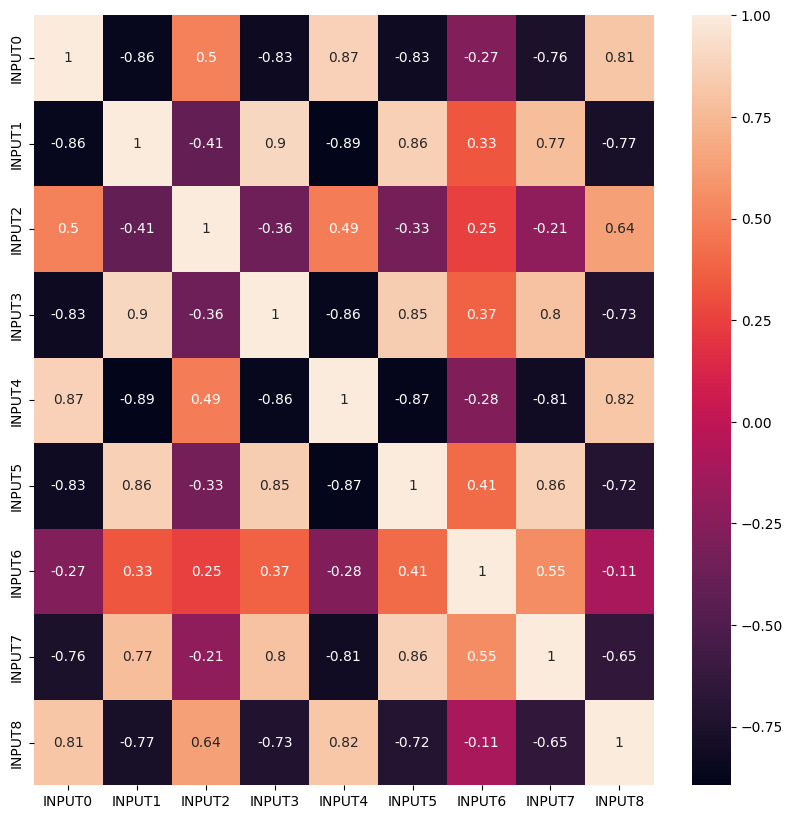

x_test_cup (529, 9)


In [3]:
from set_extraction_cup import x_test_cup

In [4]:
x_train = x_train.astype(np.float32)
y_train = y_train.astype(np.float32)
x_test = x_test.astype(np.float32)
y_test = y_test.astype(np.float32)
x_test_cup = x_test_cup.astype(np.float32)

# Models

In [5]:
from sklearn.metrics import make_scorer

from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import load_model
import torch.nn as nn
import torch.optim as optim
import torch
from tensorflow.math import reduce_mean, sqrt, reduce_sum, square
from skorch.helper import predefined_split
from skorch.dataset import Dataset

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
def MEEg(actual, predict):

    return np.mean(np.linalg.norm(actual - predict, axis=1))

In [8]:
def MEE(actual, predict):
    
    return reduce_mean(sqrt(reduce_sum(square(actual - predict), axis=-1)))

# Model Assesment Ensemble

In [9]:
in_dim = x_train.shape[1]
out_dim = y_train.shape[1]

In [10]:
# Define the class for single layer NN 
class mlp_net(nn.Module):    
    # Constructor
    def __init__(self, h_units, num_hidden_layers, activation, dropout_rate):
        #super(mlp_net, self).__init__()
        super().__init__()

        self.layers = []
        self.acts = []
        self.drops = []

        self.layers.append(nn.Linear(in_dim, h_units))
        self.acts.append(activation())
        if dropout_rate != 0:
            self.drops.append(nn.Dropout(dropout_rate))
            self.add_module(f"dro0", self.drops[-1])
        self.add_module(f"layer0", self.layers[-1])
        self.add_module(f"act0", self.acts[-1])
        

        for i in range(1, num_hidden_layers+1):
            #h_units_out = h_units - 10  DA PROVARE SENZA
            h_units_out = h_units
            self.layers.append(nn.Linear(h_units, h_units_out))
            self.acts.append(activation())
            if dropout_rate != 0:
                self.drops.append(nn.Dropout(dropout_rate))
                self.add_module(f"dro{i}", self.drops[-1])
            self.add_module(f"layer{i}", self.layers[-1])
            self.add_module(f"act{i}", self.acts[-1])
            #h_units = h_units_out DA PROVARE SENZA

        self.output = nn.Linear(h_units, out_dim)
        
    # prediction function
    def forward(self, x):

        if len(self.drops) > 0:
            for layer, act, dro in zip(self.layers, self.acts, self.drops):
                x = act(layer(x))
                x = dro(x)
        else:
            for layer, act in zip(self.layers, self.acts):
                x = act(layer(x))
        x = self.output(x)
        
        return x

In [11]:
# Top-5 Rank based on validation score
keras = load_model('cup_models/keras_median.h5', custom_objects={"MEE": MEE})
knr = joblib.load('cup_models/knr2.z')
pytorch = joblib.load('cup_models/pytorch_median.z')
mlp = joblib.load("cup_models/mlp.z")
svr = joblib.load('cup_models/svr.z')

In [12]:
keras.summary()

Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_102 (Dense)           (None, 40)                400       
                                                                 
 dense_103 (Dense)           (None, 2)                 82        
                                                                 
Total params: 482
Trainable params: 482
Non-trainable params: 0
_________________________________________________________________


In [13]:
knr

KNeighborsRegressor(n_neighbors=16)

In [14]:
pytorch

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=mlp_net(
    (layer0): Linear(in_features=9, out_features=40, bias=True)
    (act0): Tanh()
    (layer1): Linear(in_features=40, out_features=40, bias=True)
    (act1): Tanh()
    (output): Linear(in_features=40, out_features=2, bias=True)
  ),
)

In [15]:
mlp

MLPRegressor(activation='tanh', alpha=0, batch_size=16, early_stopping=True,
             hidden_layer_sizes=(50, 50, 50), learning_rate_init=0.01,
             max_iter=100, momentum=0.0, n_iter_no_change=20,
             nesterovs_momentum=False, random_state=42, solver='sgd', tol=0,
             validation_fraction=0.2)

In [16]:
svr

MultiOutputRegressor(estimator=SVR(C=3, gamma='auto', shrinking=False))

In [17]:
from sklearn.model_selection import learning_curve

### Bundling our previous work into a function ###
def learning_curves(estimator, x, y, train_sizes, cv):

    scoring = make_scorer(MEEg, greater_is_better=False)

    train_sizes, train_scores, validation_scores = learning_curve(estimator, x, y, train_sizes=train_sizes,
                                                                cv = cv, scoring = scoring)
    train_scores_mean = -train_scores.mean(axis = 1)
    validation_scores_mean = -validation_scores.mean(axis = 1)

    plt.plot(train_sizes, train_scores_mean, label = 'Training error')
    plt.plot(train_sizes, validation_scores_mean, label = 'Validation error', linestyle='dashed')

    plt.ylabel('MEE', fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14)
    title = 'Learning curves for a ' + str(estimator).split('(')[0] + ' model'
    plt.title(title, fontsize = 10, y = 1.03)
    plt.legend()
    plt.ylim(0,2)

  epoch       MEE    train_loss    valid_MEE    valid_loss     dur
-------  --------  ------------  -----------  ------------  ------
      1  -28.5832      422.7877     -24.8160      314.8882  0.0936
      2  -18.2895      186.5246      -8.0236       37.2789  0.0163
      3  -6.1085       22.3423      -5.5924       19.0135  0.0090
      4  -4.7014       13.4366      -5.0003       15.7063  0.0081
      5  -4.1330       10.7748      -4.5089       13.1061  0.0000
      6  -3.7149        8.8433      -4.1102       11.0648  0.0000
      7  -3.3742        7.3620      -3.7322        9.3549  0.0000
      8  -3.0713        6.1697      -3.4143        7.9881  0.0080
      9  -2.8071        5.2332      -3.1669        6.9233  0.0080
     10  -2.5815        4.5086      -2.9718        6.1023  0.0080
     11  -2.3940        3.9512      -2.8171        5.4719  0.0086
     12  -2.2379        3.5228      -2.6973        4.9869  0.0045
     13  -2.1122        3.1922      -2.6073        4.6110  0.0080
     1

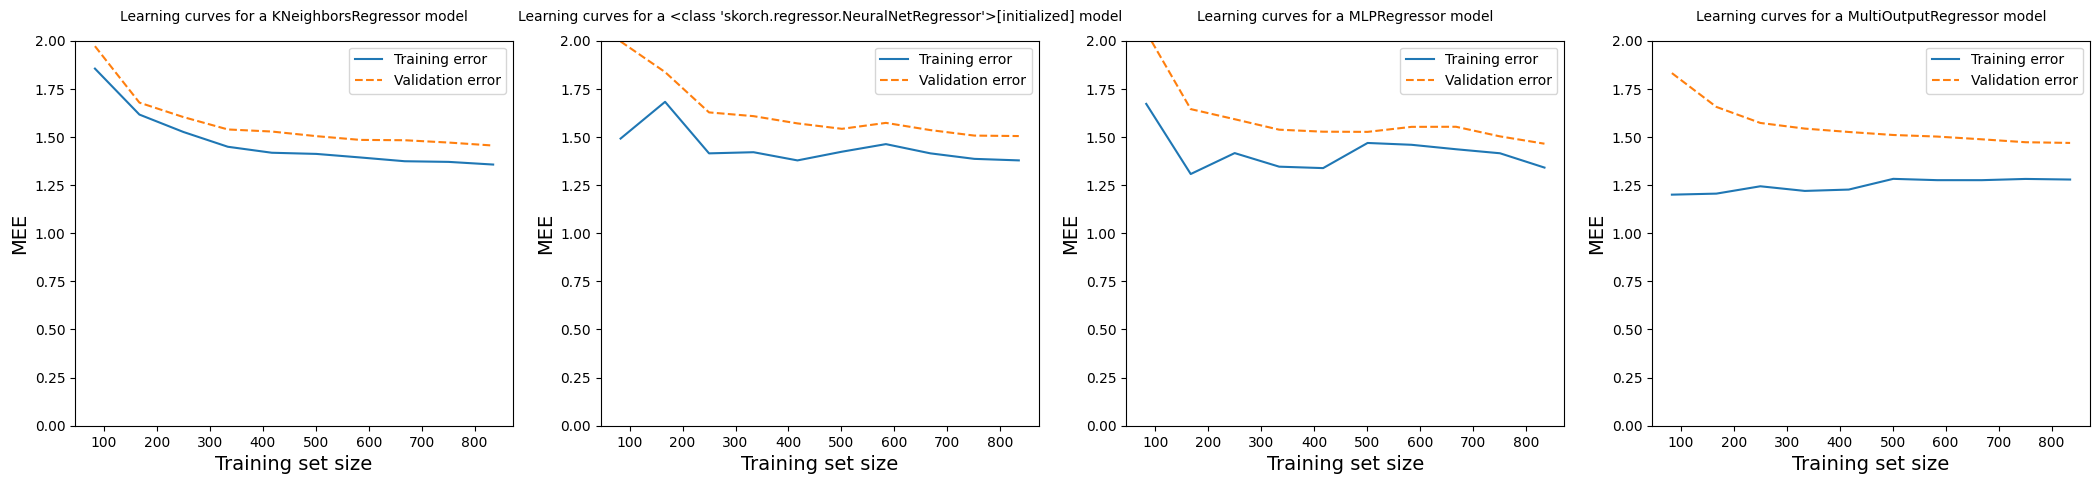

In [18]:
# Plotting the learning curves 
# keras model plot in cup_mlp_keras.ipynb file

plt.figure(figsize = (26,5))

for model, i in [(knr, 1), (pytorch, 2), (mlp, 3), (svr, 4)]:
    plt.subplot(1,4,i)
    learning_curves(model, x_train, y_train, [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 5)

In [19]:
train_pred_keras = keras.predict(x_train)
test_pred_keras = keras.predict(x_test)

train_pred_knr = knr.predict(x_train)
test_pred_knr = knr.predict(x_test)

train_pred_pytorch = pytorch.predict(x_train)
test_pred_pytorch = pytorch.predict(x_test)

train_pred_mlp = mlp.predict(x_train)
test_pred_mlp = mlp.predict(x_test)

train_pred_svr = svr.predict(x_train)
test_pred_svr = svr.predict(x_test)

14/14 [==============================] - 0s 1ms/step


In [20]:
# Model assesment

train_pred_all = np.mean([train_pred_keras, train_pred_knr, train_pred_pytorch, train_pred_mlp, train_pred_svr], axis=0)
test_pred_all = np.mean([test_pred_keras, test_pred_knr, test_pred_pytorch, test_pred_mlp, test_pred_svr], axis=0)

print('Mean MEE train set', MEEg(y_train, train_pred_all))
print('Mean MEE test set', MEEg(y_test, test_pred_all))

Mean MEE train set 1.3112948696981244
Mean MEE test set 1.4349167650387133


[Text(0.5, 0, 'target_x'),
 Text(0, 0.5, 'target_y'),
 Text(0.5, 1.0, 'Ensemble behaviour on the internal test set')]

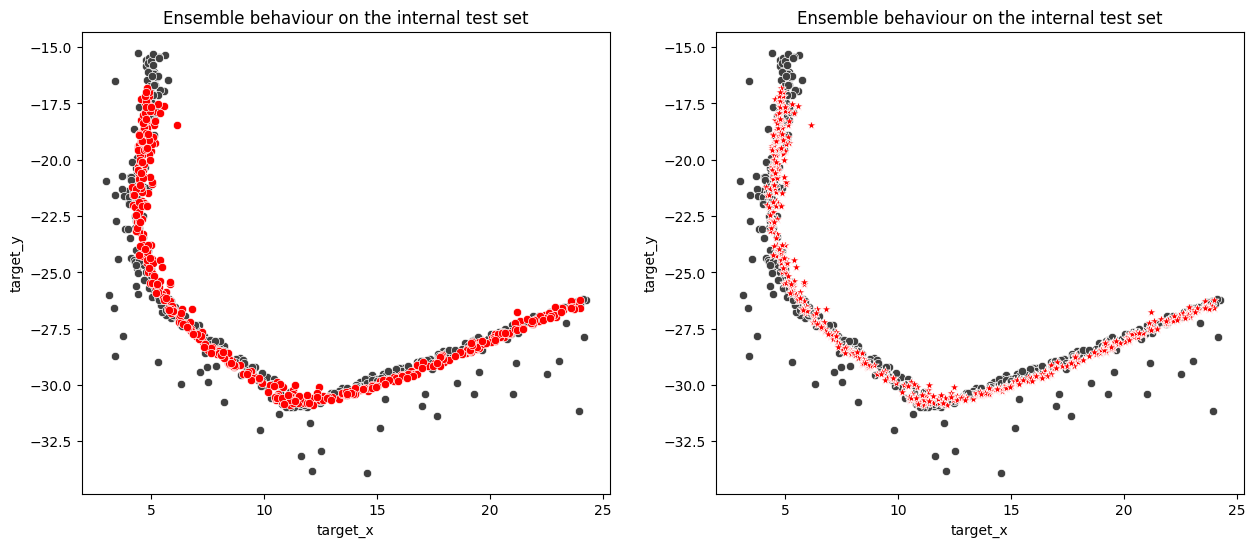

In [21]:
fig, ax = plt.subplots(1,2,figsize=(15,6))

sns.scatterplot(x=y_test[:,0],y=y_test[:,1],color='.25',ax=ax[0])
sns.scatterplot(x=test_pred_all[:,0],y=test_pred_all[:,1],color='r',ax=ax[0])
ax[0].set(xlabel='target_x',ylabel='target_y',title='Ensemble behaviour on the internal test set')

sns.scatterplot(x=y_test[:,0],y=y_test[:,1],color='.25',ax=ax[1])
sns.scatterplot(x=test_pred_all[:,0],y=test_pred_all[:,1],color='r',ax=ax[1], marker='*', s=50)
ax[1].set(xlabel='target_x',ylabel='target_y',title='Ensemble behaviour on the internal test set')

[Text(0.5, 0, 'target_x'),
 Text(0, 0.5, 'target_y'),
 Text(0.5, 1.0, 'Ensemble behaviour on the internal test set')]

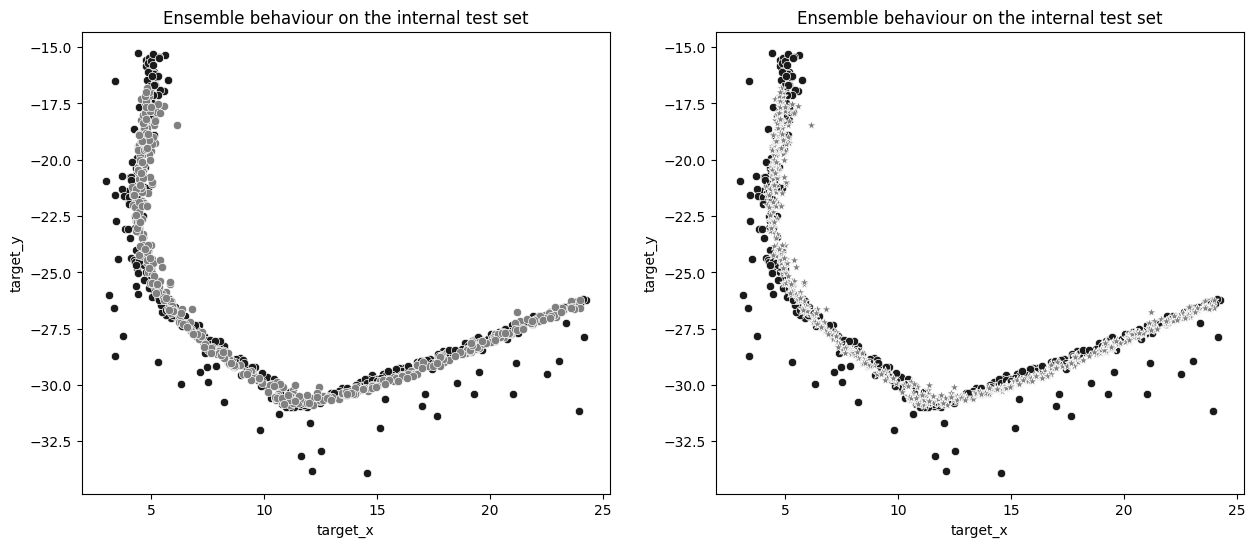

In [22]:
fig, ax = plt.subplots(1,2,figsize=(15,6))

sns.scatterplot(x=y_test[:,0],y=y_test[:,1],color='.1',ax=ax[0])
sns.scatterplot(x=test_pred_all[:,0],y=test_pred_all[:,1],color='.5',ax=ax[0])
ax[0].set(xlabel='target_x',ylabel='target_y',title='Ensemble behaviour on the internal test set')

sns.scatterplot(x=y_test[:,0],y=y_test[:,1],color='.1',ax=ax[1])
sns.scatterplot(x=test_pred_all[:,0],y=test_pred_all[:,1],color='.5',ax=ax[1], marker='*', s=50)
ax[1].set(xlabel='target_x',ylabel='target_y',title='Ensemble behaviour on the internal test set')

# ML CUP

In [23]:
test_pred_keras_cup = keras.predict(x_test_cup)

test_pred_knr_cup = knr.predict(x_test_cup)

test_pred_pytorch_cup = pytorch.predict(x_test_cup)

test_pred_mlp_cup = mlp.predict(x_test_cup)

test_pred_svr_cup = svr.predict(x_test_cup)

17/17 [==============================] - 0s 502us/step


In [24]:
test_pred_all_cup = np.mean([test_pred_keras_cup, test_pred_knr_cup, test_pred_pytorch_cup, test_pred_mlp_cup, test_pred_svr_cup], axis=0)

In [25]:
# check output shape
test_pred_all_cup.shape   

(529, 2)

In [26]:
df = pd.DataFrame(test_pred_all_cup)
date = datetime.datetime.now()
f = open('cup_output/Ladydebugs_ML-CUP22-TS.csv', 'w')
f.write('# Veronica Pistolesi, Francesca Poli\n')
f.write('# Ladydebugs\n')
f.write('# ML-CUP22\n')
f.write('# '+str(date.day)+'/'+str(date.month)+'/'+str(date.year)+'\n')
df.index += 1 
df.to_csv(f, sep=',', encoding='utf-8', header = False, lineterminator='\n')
f.close()